In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import numpy as np

# SVM Trained on Healthy predicted data

## Data Load

In [13]:
# Define patient groups
PATIENT_GROUPS = {
    'AD': (1, 36),      # Alzheimer's Disease patients
    'Healthy': (37, 65), # Healthy patients
    'FTD': (66, 88)     # Frontotemporal Dementia patients
}

In [14]:
data_list = ['y_pred', 'y_true', 'xf', 'yf_pred', 'yf_true']
attempt = '' 
# Load the data from the npz file in plots
healthy_data = {}
ad_on_healthy_data = {}
ftd_on_healthy_data = {}
print("Loading data...")
for i in data_list:
    healthy_data[i] = np.load(f'plots/fft_data_Healthy_Trained on_Healthy_frontal_electrodes{attempt}.npz')[i]
    ad_on_healthy_data[i] = np.load(f'plots/fft_data_AD_Trained on_Healthy_frontal_electrodes{attempt}.npz')[i]
    ftd_on_healthy_data[i] = np.load(f'plots/fft_data_FTD_Trained on_Healthy_frontal_electrodes{attempt}.npz')[i]
print("Data loaded.")

print("Predicted AD data shape:", ad_on_healthy_data['y_pred'].shape)
print("Predicted Healthy data shape:", healthy_data['y_pred'].shape)
print("Predicted FTD data shape:", ftd_on_healthy_data['y_pred'].shape)

Loading data...
Data loaded.
Predicted AD data shape: (930, 2500, 6)
Predicted Healthy data shape: (930, 2500, 6)
Predicted FTD data shape: (629, 2500, 6)


## Feature Extraction

Time Domain Features

In [15]:
# Extract time-domain features from predicted signals
def extract_features(y_pred, label):
  features = []
  for pred in y_pred:
    flat = pred.flatten()
    features.append({
      'group': label,
      'mean': np.mean(flat),
      'std': np.std(flat),
      'skewness': skew(flat),
      'kurtosis': kurtosis(flat),
      'signal_power': np.sum(flat ** 2)
    })
  return features

# Use your existing variables for predicted data
ad_feats = extract_features(ad_on_healthy_data['y_pred'], 'AD')
ftd_feats = extract_features(ftd_on_healthy_data['y_pred'], 'FTD')
hc_feats = extract_features(healthy_data['y_pred'], 'Healthy')

# Combine into a single DataFrame
df_features = pd.DataFrame(ad_feats + ftd_feats + hc_feats)

# Display and optionally save
print(df_features.groupby("group").mean())


             mean       std  skewness  kurtosis  signal_power
group                                                        
AD       0.519223  0.078075 -0.100223 -0.389506   4583.417969
FTD      0.466701  0.088740 -0.012120 -0.424349   3548.848145
Healthy  0.505692  0.076103 -0.110084 -0.433023   4137.140137


Frequency Domain Features

In [16]:
# EEG frequency bands
bands = {
  'delta': (0.5, 4),
  'theta': (4, 8),
  'alpha': (8, 13),
  'beta': (13, 30),
  'gamma': (30, 45)
}

SAMPLING_RATE = 250  # Adjust if different

def extract_band_power(y_pred, group_label):
  features = []
  for sample in y_pred:
    signal = sample.flatten()
    freqs, psd = welch(signal, fs=SAMPLING_RATE, nperseg=SAMPLING_RATE*2)
    powers = {}
    for band, (low, high) in bands.items():
      idx = np.logical_and(freqs >= low, freqs <= high)
      powers[band] = np.trapz(psd[idx], freqs[idx])
    powers['group'] = group_label
    features.append(powers)
  return features

# Apply to each group using your variable names
bp_ad = extract_band_power(ad_on_healthy_data['y_pred'], 'AD')
bp_ftd = extract_band_power(ftd_on_healthy_data['y_pred'], 'FTD')
bp_healthy = extract_band_power(healthy_data['y_pred'], 'Healthy')

# Combine into single DataFrame
df_bandpowers = pd.DataFrame(bp_ad + bp_ftd + bp_healthy)

C:\Users\orben\AppData\Local\Temp\ipykernel_15036\3946877203.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  powers[band] = np.trapz(psd[idx], freqs[idx])


In [17]:
# Merge time and frequency features
df_model_healthy = pd.concat([
  df_features.set_index('group'),
  df_bandpowers.set_index('group')
], axis=1).reset_index()

## SVM

### Single  SVM - Predicted data

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.82      0.81      0.81       186
          AD       0.78      0.61      0.69       186
         FTD       0.60      0.81      0.69       126

    accuracy                           0.73       498
   macro avg       0.73      0.74      0.73       498
weighted avg       0.75      0.73      0.74       498

Average accuracy: 0.6074373954570799


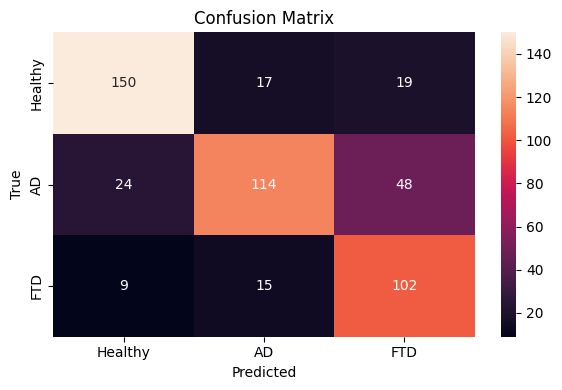

In [18]:
# Encode target labels
df_model_healthy['label'] = df_model_healthy['group'].map({'Healthy': 0, 'AD': 1, 'FTD': 2})

# Prepare features and target
X = df_model_healthy.drop(columns=['group', 'label'])  # all features
y = df_model_healthy['label']  # encoded label

# Train-test split (stratified to balance classes)
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, stratify=y
)

# Create a pipeline: scaling + SVM classifier
svm_model = make_pipeline(
  StandardScaler(),
  SVC(kernel='rbf', C=1.0, gamma='scale')  # Try linear or poly kernels later
)

# Fit the model
svm_model.fit(X_train, y_train)

# Predict
y_pred = svm_model.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'AD', 'FTD']))
# Average accuracy
print("Average accuracy:", np.mean(cross_val_score(svm_model, X, y, cv=5)))
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=['Healthy', 'AD', 'FTD'],
            yticklabels=['Healthy', 'AD', 'FTD'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### Single SVM - Comparison

In [19]:
# Check the SVM preformance on actual data
# Prepare the data frame
ad_true_feats = extract_features(ad_on_healthy_data['y_true'], 'AD')
ftd_true_feats = extract_features(ftd_on_healthy_data['y_true'], 'FTD')
hc_true_feats = extract_features(healthy_data['y_true'], 'Healthy')

# Combine into a single DataFrame
df_true_features = pd.DataFrame(ad_feats + ftd_feats + hc_feats)

# Apply to each group using your variable names
bp_true_ad = extract_band_power(ad_on_healthy_data['y_pred'], 'AD')
bp_true_ftd = extract_band_power(ftd_on_healthy_data['y_pred'], 'FTD')
bp_true_healthy = extract_band_power(healthy_data['y_pred'], 'Healthy')

# Combine into single DataFrame
df_true_bandpowers = pd.DataFrame(bp_ad + bp_ftd + bp_healthy)


df_true = pd.concat([
  df_features.set_index('group'),
  df_bandpowers.set_index('group')
], axis=1).reset_index()

# Encode target labels
df_true['label'] = df_true['group'].map({'Healthy': 0, 'AD': 1, 'FTD': 2})

# Prepare features and target
X_true = df_model_healthy.drop(columns=['group', 'label'])  # all features
y_true = df_model_healthy['label']  # encoded label

# Train-test split (stratified to balance classes)
X_train_true, X_test_true, y_train_true, y_test_true = train_test_split(
  X, y, test_size=0.2, stratify=y)

C:\Users\orben\AppData\Local\Temp\ipykernel_15036\3946877203.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  powers[band] = np.trapz(psd[idx], freqs[idx])


Classification Report on True Data:
              precision    recall  f1-score   support

     Healthy       0.83      0.81      0.82       186
          AD       0.78      0.70      0.74       186
         FTD       0.67      0.79      0.72       126

    accuracy                           0.77       498
   macro avg       0.76      0.77      0.76       498
weighted avg       0.77      0.77      0.77       498



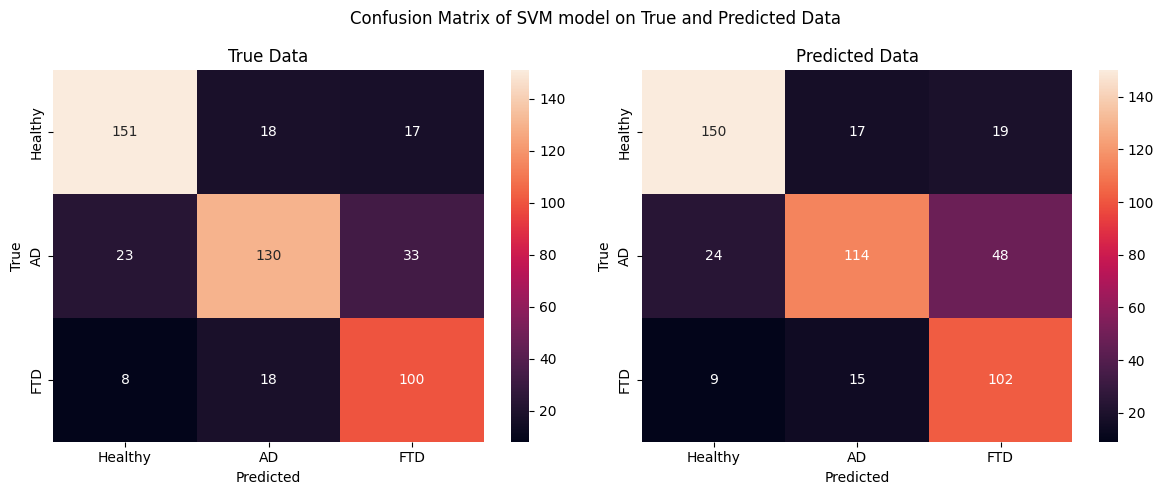

In [20]:
# Evcaluate the model on the actual data
y_pred_true = svm_model.predict(X_test_true)
# Evaluation
print("Classification Report on True Data:")
report = classification_report(y_test_true, y_pred_true, target_names=['Healthy', 'AD', 'FTD'])
print(report)


# Confusion matrix
conf_mat_true = confusion_matrix(y_test_true, y_pred_true)

# Plot confusion matrices: on true data and on prediction
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(conf_mat_true, annot=True, fmt="d",
            xticklabels=['Healthy', 'AD', 'FTD'],
            yticklabels=['Healthy', 'AD', 'FTD'], ax=axes[0])
axes[0].set_title("True Data")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=['Healthy', 'AD', 'FTD'],
            yticklabels=['Healthy', 'AD', 'FTD'], ax=axes[1])
axes[1].set_title("Predicted Data")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

fig.suptitle("Confusion Matrix of SVM model on True and Predicted Data")
plt.tight_layout()

### Average SVM of 10,000 Iterations - Comparison

Average test set size: 498.0
Average test set size on true data: 498.0
Average Classification Report for predicted data:
     Label  F1-Score  Precision    Recall
0  Healthy  0.809232   0.806504  0.812935
1       AD  0.687941   0.742003  0.642508
2      FTD  0.690405   0.638121  0.753590
Average Classification Report for true data:
     Label  F1-Score  Precision    Recall
0  Healthy  0.822809   0.819435  0.826958
1       AD  0.713870   0.768152  0.667790
2      FTD  0.713463   0.660788  0.776517


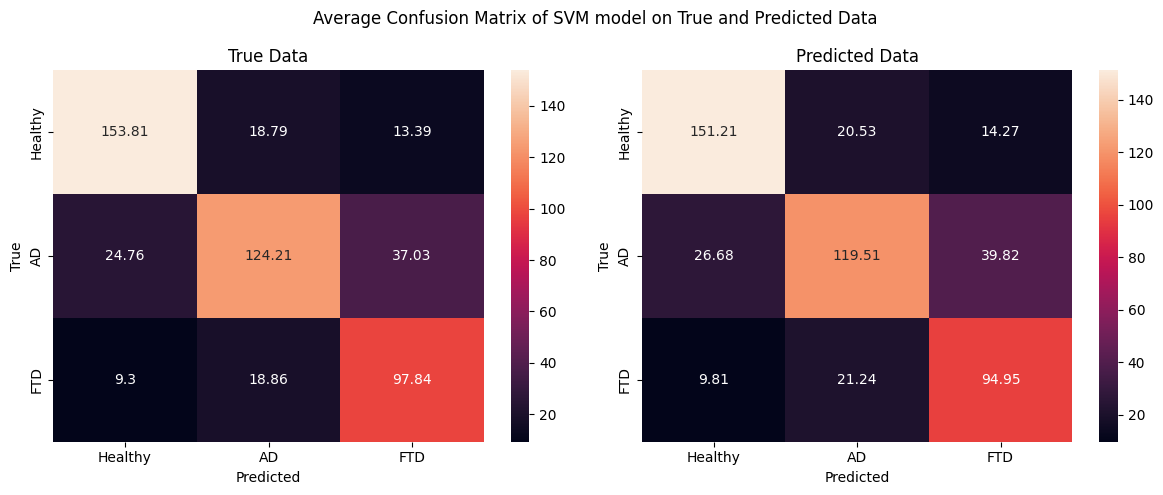

In [21]:
# Create a confucsion matrix over 1000 iterations
conf_matrices = []
classification_reports = []
classification_reports_true = []
conf_matrices_true = []
x_test_size = []
x_test_true_size = []
for n in range(10000):
  X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=n)
  
  X_train_true, X_test_true, y_train_true, y_test_true = train_test_split(
    X, y, test_size=0.2, stratify=y)
  svm_model = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, gamma='scale')
  )

  svm_model.fit(X_train, y_train)
  y_pred = svm_model.predict(X_test)

  conf_mat = confusion_matrix(y_test, y_pred)
  conf_matrices.append(conf_mat)

  report = classification_report(y_test, y_pred, output_dict=True)
  classification_reports.append(report)

  # Evcaluate the model on the actual data
  y_pred_true = svm_model.predict(X_test_true)
  conf_mat_true = confusion_matrix(y_test_true, y_pred_true)
  conf_matrices_true.append(conf_mat_true)
  # Evaluation
  report_true = classification_report(y_test_true, y_pred_true, output_dict=True)
  classification_reports_true.append(report_true)
  # Append the size of the test set
  x_test_size.append(X_test.shape[0])
  x_test_true_size.append(X_test_true.shape[0])

# Average confusion matrix
avg_conf_mat = np.round(np.mean(conf_matrices, axis=0),2)
avg_conf_mat_true = np.round(np.mean(conf_matrices_true, axis=0),2)
# Plot average confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(avg_conf_mat_true, annot=True, fmt="g",
            xticklabels=['Healthy', 'AD', 'FTD'],
            yticklabels=['Healthy', 'AD', 'FTD'], ax=axes[0])
axes[0].set_title("True Data")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(avg_conf_mat, annot=True, fmt="g",
            xticklabels=['Healthy', 'AD', 'FTD'],
            yticklabels=['Healthy', 'AD', 'FTD'], ax=axes[1])
axes[1].set_title("Predicted Data")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

fig.suptitle("Average Confusion Matrix of SVM model on True and Predicted Data")
plt.tight_layout()

# Compare average test set size
print(f"Average test set size: {np.mean(x_test_size)}")
print(f"Average test set size on true data: {np.mean(x_test_true_size)}")

# Average classification report
avg_report = {}
avg_report_true = {}
label_names = {0: 'Healthy', 1: 'AD', 2: 'FTD'}

# Initialize nested dict
for label in label_names.values():
    avg_report[label] = {'f1-score': 0, 'precision': 0, 'recall': 0}
    avg_report_true[label] = {'f1-score': 0, 'precision': 0, 'recall': 0}

# Compute averages
for i in [0, 1, 2]:
    class_key = str(i)
    label = label_names[i]
    avg_report[label]['f1-score'] = np.mean([r[class_key]['f1-score'] for r in classification_reports])
    avg_report[label]['precision'] = np.mean([r[class_key]['precision'] for r in classification_reports])
    avg_report[label]['recall'] = np.mean([r[class_key]['recall'] for r in classification_reports])
    avg_report_true[label]['f1-score'] = np.mean([r[class_key]['f1-score'] for r in classification_reports_true])
    avg_report_true[label]['precision'] = np.mean([r[class_key]['precision'] for r in classification_reports_true])
    avg_report_true[label]['recall'] = np.mean([r[class_key]['recall'] for r in classification_reports_true])

# Display average classification report in a table format
avg_report_df = pd.DataFrame(avg_report).T
avg_report_df.index.name = 'Label'
avg_report_df.reset_index(inplace=True)
avg_report_df.columns = ['Label', 'F1-Score', 'Precision', 'Recall']
print("Average Classification Report for predicted data:")
print(avg_report_df)
avg_report_true_df = pd.DataFrame(avg_report_true).T
avg_report_true_df.index.name = 'Label'
avg_report_true_df.reset_index(inplace=True)
avg_report_true_df.columns = ['Label', 'F1-Score', 'Precision', 'Recall']
print("Average Classification Report for true data:")
print(avg_report_true_df)

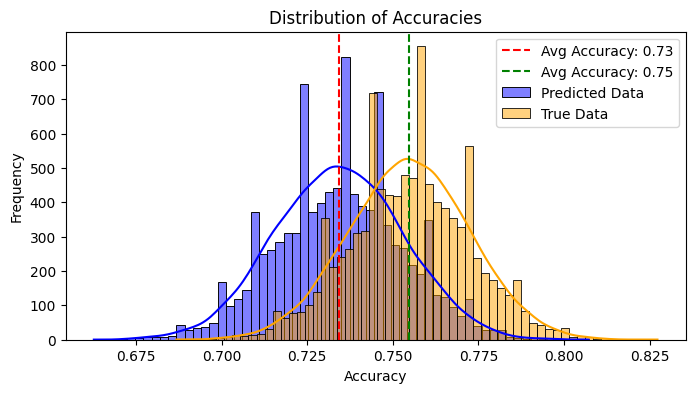

In [22]:
avg_accuracy = np.mean([r['accuracy'] for r in classification_reports])
avg_accuracy_true = np.mean([r['accuracy'] for r in classification_reports_true])
# Plot distribution of accuracies
plt.figure(figsize=(8, 4))
sns.histplot([r['accuracy'] for r in classification_reports], bins=60, kde=True, color='blue', label='Predicted Data')
sns.histplot([r['accuracy'] for r in classification_reports_true], bins=60, kde=True, color='orange', label='True Data')
plt.axvline(avg_accuracy, color='red', linestyle='--', label=f"Avg Accuracy: {avg_accuracy:.2f}")
plt.axvline(avg_accuracy_true, color='green', linestyle='--', label=f"Avg Accuracy: {avg_accuracy_true:.2f}")
plt.title("Distribution of Accuracies")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.legend()